## Basic setup

### install

In [ ]:
!pip install granular_engine
!pip install gsutil
!pip install ternausnet > /dev/null
!pip install patchify
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [ ]:
# download dataset
!mkdir Hurricane_Harvey 
!mkdir Hurricane_Harvey/rasters Hurricane_Harvey/vectors 
!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/rasters/raw Hurricane_Harvey/rasters/ 
!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/vectors/random-split-_2022_11_17-22_35_45/ Hurricane_Harvey/vectors/

### import packages

In [1]:
%matplotlib inline

## Generic Python imports
import os, sys
import matplotlib.pyplot as plt

## Generic database imports
import pandas as pd
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report 

# Progress bar in Colab
from tqdm import tqdm

# Download the CIFAR10 dataset using the PyTorch dataloaders
import json 
from pprint import pprint
import torch
torch.cuda.empty_cache()
import torchvision
import torchvision.transforms as transforms

import cv2


import tarfile 
from PIL import Image 


import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2


import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader


# from patchify import patchify, unpatchify

# import gc
# gc.collect()


from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report 



In [2]:
# release cuda memory
from numba import cuda 
device = cuda.get_current_device()
device.reset()

### Examine the size of images

In raster - raws
Examine the size of images

In [ ]:
import cv2

# specify the path to the folder
folder_path = '/content/Hurricane_Harvey/rasters/raw'

# use the os.listdir() function to get a list of all files in the folder
files = os.listdir(folder_path)

sizes = dict()



for f in files: 
  path = os.path.join('/content/Hurricane_Harvey/rasters/raw', f)
  #print(path)
  img = cv2.imread(path)
  (w,f) =(img.shape[0], img.shape[1])
  size = (w,f)
  if size in sizes.keys():
    sizes[size] += 1
  else:
    sizes[size] = 1

# Convert the image to a numpy array
sizes

# output : {(3000, 4000): 263, (3072, 4592): 111}

KeyboardInterrupt: ignored

### Settings

In [3]:
images_directory = os.path.join("/content/Hurricane_Harvey/rasters/raw")
mask_directory = os.path.join("/content/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks")

**bold text**#### Split files from the dataset into the train and validation sets¶

In [4]:
images_filenames = list(sorted(os.listdir(images_directory)))
mask_filenames = list(sorted(os.listdir(mask_directory)))
# pre_mask_filenames = list(sorted(os.listdir(pre_mask_directory)))
processed_images_filenames = [i for i in images_filenames if i.split(".")[0]+".png" in mask_filenames]
test_images_filesnames = [i for i in images_filenames if i not in processed_images_filenames]

In [5]:
# splitting the data
import random
random.seed(42)
random.shuffle(processed_images_filenames)
train_images_filenames = processed_images_filenames[:224]
val_images_filenames = [i for i in processed_images_filenames if i not in train_images_filenames]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filesnames))

224 75 75


##### sliceing images and patches

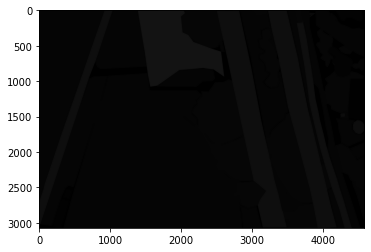

In [ ]:
train_mask_filenames = [os.path.splitext(filename)[0]+'.png' for filename in train_images_filenames]
val_mask_filenames = [os.path.splitext(filename)[0]+'.png' for filename in val_images_filenames]

def crop_patch_save(images_filenames, images_directory, patch_size, n_channel, path_to_save, extension): 
    i = 0
    for j in range(len(images_filenames)): 
      path = os.path.join(images_directory, images_filenames[i])
      image = cv2.imread(path) #grey level = 0
      # print(image.shape)
      #image = cv2.resize(image, (resize_w, resize_h))
      size_w = (image.shape[1] // patch_size) * patch_size #width
      # print(size_w)
      size_h = (image.shape[0] // patch_size) * patch_size #height
      # print(size_h)
      image = Image.fromarray(image) #array object no crop function, convert to image object first 
      plt.imshow(image)
      image = np.array(image.crop((0, 0, size_w, size_h)))
      # print(image.shape)
        
      patch_img = patchify(image, (patch_size, patch_size, n_channel), step=patch_size)
      # print(patch_img.shape)
      
      for a in range(patch_img.shape[0]):
        for b in range(patch_img.shape[1]):
          single_patch_img = patch_img[a, b] #indice single patch image [height, width]
          single_patch_img1 = single_patch_img.reshape(patch_size, patch_size, n_channel)
          os.chdir(path_to_save)
          filename = str(images_filenames[i]) + '_' + str(a) + '_' + str(b) + extension
          cv2.imwrite(filename, single_patch_img1)
          # print(single_patch_img1.shape)
      i +=1

! mkdir Hurricane_Harvey/patches_train_images Hurricane_Harvey/patches_train_mask Hurricane_Harvey/patches_val_images Hurricane_Harvey/patches_val_mask
crop_patch_save(train_images_filenames, images_directory, 1024, 3, '/content/Hurricane_Harvey/patches_train_images', '.tif')
crop_patch_save(train_mask_filenames, mask_directory, 1024, 1, '/content/Hurricane_Harvey/patches_train_mask', '.png')
crop_patch_save(val_images_filenames, images_directory, 1024, 3, '/content/Hurricane_Harvey/patches_val_images', '.tif')
crop_patch_save(val_mask_filenames, mask_directory, 1024, 1, '/content/Hurricane_Harvey/patches_val_mask', '.png')

In [ ]:
patahed_train_images_directory = os.path.join("/content/Hurricane_Harvey/patches_train_images")
patched_train_mask_directory = os.path.join("/content/Hurricane_Harvey/patches_train_mask")
patched_val_images_directory = os.path.join("/content/Hurricane_Harvey/patches_val_images")
patched_val_mask_directory = os.path.join("/content/Hurricane_Harvey/patches_val_mask")

In [ ]:
patched_train_images_filenames = list(sorted(os.listdir(patahed_train_images_directory)))
patched_val_images_filenames = list(sorted(os.listdir(patched_val_images_directory)))

In [ ]:

print(len(patched_train_images_filenames), len(patched_val_images_filenames), len(test_images_filesnames))

1686 594 75


#### Define a function to preprocess a mask

In [6]:
# check after - not very useful
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    return mask


#### Define a function to visualize images and their labels

In [7]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # print("image", image.shape)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".tif", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        # print("mask", mask.shape)
        if image.shape[0] != mask.shape[0] or image.shape[1] != mask.shape[1]:
          print("Different", image_filename)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

In [8]:
test_filenames = train_images_filenames[:10]
# print(test_filenames)


In [9]:
# display_image_grid(test_filenames, images_directory, mask_directory, predicted_masks=None)

#### data transformation and dataloader

In [10]:
class HurricaneDataset(Dataset):
  def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        print(len(images_filenames))
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
        images = []
        masks = []
        for i in range(0, len(images_filenames)):
          image_filename = self.images_filenames[i]
          # print("image_filename", image_filename)
          image = cv2.imread(os.path.join(self.images_directory, image_filename))
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = np.asarray(image,dtype="float32")
              

          mask = cv2.imread(
              os.path.join(self.masks_directory, image_filename.replace(".tif", ".png")), cv2.IMREAD_UNCHANGED,
          )
          mask = preprocess_mask(mask)
          if self.transform is not None:
              transformed = self.transform(image=image, mask=mask)
              image = transformed["image"]
              mask = transformed["mask"]
          images.append(image)
          masks.append(mask)
          self.images = images
          self.masks = masks

  def __len__(self):
        return len(self.images_filenames)


  def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        # print("image_filename", image_filename)
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.asarray(image,dtype="float32")
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".tif", ".png")), cv2.IMREAD_UNCHANGED,
        )
        mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask
  


In [11]:
class HurricaneDatasetTest(Dataset):
  def __init__(self, images_filenames, images_directory, transform=None):
        print(len(images_filenames))
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

  def __len__(self):
        return len(self.images_filenames)


  def show(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.asarray(image,dtype="float32")
        return image

  def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        # print("image_filename", image_filename)
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.asarray(image,dtype="float32")
        (w,f) =(image.shape[0], image.shape[1])
        size = (w,f)
            
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, size
  def showShape(self):
        shape_list = []
        for i in range(0, len(self.images_filenames)):
          image_filename = self.images_filenames[i]
          image = cv2.imread(os.path.join(self.images_directory, image_filename))
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = np.asarray(image,dtype="float32")
          (w,f) =(image.shape[0], image.shape[1])
          size = (w,f)
          shape_list.append(size)
        return shape_list

In [16]:
# define transformer
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.GaussNoise(var_limit=(10,50), mean=0, p=0.5),
        ToTensorV2(),
    ]
)


val_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
)

In [17]:
train_dataset = HurricaneDataset(train_images_filenames, images_directory, mask_directory, transform=train_transform,)
test_dataset = HurricaneDatasetTest(test_images_filesnames, images_directory, transform=val_transform)
val_dataset = HurricaneDataset(val_images_filenames, images_directory, mask_directory, transform=val_transform,)

224
75
75


In [18]:
shape_list = test_dataset.showShape()

In [19]:
# dataloader
BATCH_SIZE = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


### define Unet model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        # logits = torch.nn.Softmax(dim=1)(logits)
        logits = torch.nn.Sigmoid()(logits)
        return logits

### Apply Resnet model from pytorch

In [20]:

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as utils

In [22]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=27, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [28]:
# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)
# define loss function
# loss = utils.losses.DiceLoss()
# loss = nn.CrossEntropyLoss() 
# loss = FocalLoss(gamma=3/4).to(DEVICE)
criterion = FocalLoss(gamma=3/4).to(DEVICE)

# define metrics
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
    model = torch.load('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

In [27]:
min_loss = torch.tensor(float('inf'))
criterion = nn.CrossEntropyLoss() 
total_loss_list = []
total_acc_list = []
total_val_loss_list = []
total_val_acc_list = []
scheduler_counter = 0
plot_losses = []

In [35]:
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [37]:
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 5
N_DATA = len(train_dataset)
N_TEST = len(val_dataset)

# plot_losses = []
# scheduler_counter = 0


loss_list = []
acc_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(N_EPOCHS):
  print("scheduler_counter", scheduler_counter)
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):


      pred_mask = model(x.to(DEVICE).to(torch.float32)) 
      pred_mask = pred_mask.to(torch.float32)

      loss = criterion(pred_mask, y.to(DEVICE).to(torch.int64))


      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(val_dataloader):
      with torch.no_grad():    
          pred_mask = model(x.to(DEVICE))  
      val_loss = criterion(pred_mask, y.to(DEVICE).to(torch.int64))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
    
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
                                                                                                 np.mean(loss_list), 
                                                                                                 np.mean(acc_list), 
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))

  total_val_loss_list.append(np.mean(val_loss_list))     
  total_loss_list.append(np.mean(loss_list))   
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])
  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


scheduler_counter 0
[Epoch 0/5] [Batch 6/7] [Loss: 2.572972 (2.587930)] epoch 0 - loss : 2.58793 - acc : 0.33 - val loss : 2.50196 - val acc : 0.48
scheduler_counter 0
[Epoch 1/5] [Batch 6/7] [Loss: 2.580565 (2.587466)] epoch 1 - loss : 2.58747 - acc : 0.33 - val loss : 2.49685 - val acc : 0.47
scheduler_counter 0
[Epoch 2/5] [Batch 6/7] [Loss: 2.578588 (2.581654)] epoch 2 - loss : 2.58165 - acc : 0.33 - val loss : 2.50704 - val acc : 0.48
scheduler_counter 1
[Epoch 3/5] [Batch 6/7] [Loss: 2.572351 (2.593249)] epoch 3 - loss : 2.59325 - acc : 0.32 - val loss : 2.49916 - val acc : 0.48
scheduler_counter 2
[Epoch 4/5] [Batch 6/7] [Loss: 2.593267 (2.585512)] epoch 4 - loss : 2.58551 - acc : 0.32 - val loss : 2.49544 - val acc : 0.47


### Loss function

#### FocalLoss

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.to(device).to(torch.int64)    
        target = target.view(-1,1)
        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = FocalLoss(gamma=3/4).to(device)

#### Jaccard Loss

In [ ]:
class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)
        # c_m = confusion_matrix(target_oneHot, inputs)
        print("inter", inter)

        #Denominator 
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return 1-loss.mean()

In [ ]:
criterion = mIoULoss(n_classes=27).to(device)

#### Dice loss

In [ ]:
def one_hot_encoding(target,number_of_classes):
  batch_size_tmp = target.shape[0]
  new_true = torch.zeros((target.shape[0],
                          number_of_classes,
                          target.shape[1],
                          target.shape[2]))

  for b in range(batch_size_tmp):
    annotation = target[b]
    for i in range(number_of_classes):
      one_hot = torch.zeros((target.shape[1],target.shape[2]))
      one_hot[annotation==i] = 1
      new_true[b,i] = one_hot
  return new_true

def compute_per_channel_dice(input, target, epsilon=1e-5, ignore_index=None, weight=None):
    # assumes that input is a normalized probability
    target = one_hot_encoding(target,27)#num_of_classes)
    
    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input * mask
        target = target * mask

    input = torch.flatten(input).to(device)
    target = torch.flatten(target).to(device)
    
    target = target.float()
    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect
    # print("target", target)
    # print("input", F.softmax(input,dim=1))
    # c_m = confusion_matrix(target.cpu().detach(), input.cpu().detach())
    # print("cm",c_m)

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)

from torch.autograd import Variable
from torch.nn import MSELoss, SmoothL1Loss, L1Loss


class DiceLoss(nn.Module):
    """Computes Dice Loss, which just 1 - DiceCoefficient described above.
    Additionally allows per-class weights to be provided.
    """

    def init(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
                 skip_last_target=False):
        #super(DiceLoss, self).init()
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index
        self.weight = weight
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify sigmoid_normalization=False.
        #self.normalization = nn.Sigmoid()
        #if sigmoid_normalization:
        #    self.normalization = nn.Sigmoid()
        #else:
        #self.normalization = nn.Softmax(dim=1)
        # if True skip the last channel in the target
        self.skip_last_target = skip_last_target

    def forward(self, input, target):
        # get probabilities from logits
        normalization = torch.nn.Softmax(dim=1)
        input = normalization(input)
        weight = None

        per_channel_dice = compute_per_channel_dice(input, target, epsilon=1e-5, ignore_index=None,
                                                    weight=weight)
        # Average the Dice score across all channels/classes
        return torch.mean(1. - per_channel_dice)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = DiceLoss().to(device)

## Training

In [31]:
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

In [ ]:
# run Unet model
min_loss = torch.tensor(float('inf'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = FocalLoss(gamma=3/4).to(device)
model = UNet(n_channels=3, n_classes=27, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
# run ResNet101 model

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)
criterion = FocalLoss(gamma=3/4).to(DEVICE)

# define metrics
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [ ]:
min_loss = torch.tensor(float('inf'))
total_loss_list = []
total_acc_list = []
total_val_loss_list = []
total_val_acc_list = []

In [ ]:
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 5
N_DATA = len(train_dataset)
N_TEST = len(val_dataset)

plot_losses = []
scheduler_counter = 0


loss_list = []
acc_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):


      pred_mask = model(x.to(device).to(torch.float32)) 
      pred_mask = pred_mask.to(torch.float32)

      loss = criterion(pred_mask, y.to(device).to(torch.int64))


      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(val_dataloader):
      with torch.no_grad():    
          pred_mask = model(x.to(device))  
      val_loss = criterion(pred_mask, y.to(device).to(torch.int64))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
    
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
                                                                                                 np.mean(loss_list), 
                                                                                                 np.mean(acc_list), 
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))

  total_val_loss_list.append(np.mean(val_loss_list))     
  total_loss_list.append(np.mean(loss_list))   
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])
  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


14
5
[array(2.7221406, dtype=float32), array(2.7066002, dtype=float32), array(2.6771908, dtype=float32), array(2.6979985, dtype=float32), array(2.6905777, dtype=float32), array(2.67736, dtype=float32), array(2.707055, dtype=float32), array(2.7030776, dtype=float32), array(2.6668642, dtype=float32), array(2.7188916, dtype=float32), array(2.688739, dtype=float32), array(2.7309484, dtype=float32), array(2.6817293, dtype=float32), array(2.6992478, dtype=float32)]
[array(2.5892017, dtype=float32), array(2.620199, dtype=float32), array(2.6188617, dtype=float32), array(2.6126232, dtype=float32), array(2.6207693, dtype=float32)]


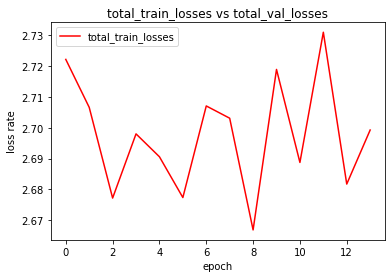

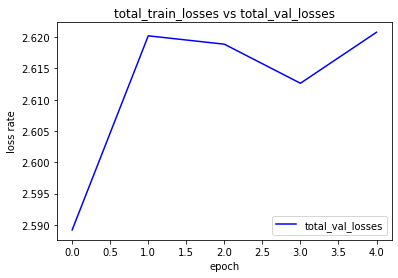

In [ ]:
# plot loss function

# importing the required module
import matplotlib.pyplot as plt

total_train_losses = []
total_val_losses = []
for i in range (0, len(loss_list)):
  total_train_losses.append(loss_list[i])


for i in range (0, len(val_loss_list)):
  total_val_losses.append(val_loss_list[i])

x = np.arange(0, len(total_train_losses), 1)
plt.plot(x,total_train_losses, label = "total_train_losses", color = "red")
plt.xlabel('epoch')
plt.ylabel('loss rate')
plt.title("total_train_losses vs total_val_losses")
# plt.plot(x, total_val_losses, label = "total_val_losses",color = "blue")
plt.legend()
plt.show()


x = np.arange(0, len(total_val_losses), 1)
# plt.plot(x,total_train_losses, label = "total_train_losses", color = "red")
plt.xlabel('epoch')
plt.ylabel('loss rate')
plt.title("total_train_losses vs total_val_losses")
plt.plot(x, total_val_losses, label = "total_val_losses",color = "blue")
plt.legend()
plt.show()

# Submission

In [ ]:


idx = 0
for batch_i, (x, size) in enumerate(test_dataloader):

    for j in range(len(x)):

      pre_test = model(x.to(device)[j:j+1].to(torch.float32)) 
      mask = torch.argmax(pre_test, axis=1).cpu().detach().numpy()[0]

      name = test_images_filesnames[idx].replace(".tif",".png")

      predicted_mask = cv2.resize(mask, (shape_list[idx][1], shape_list[idx][0]), 
                            interpolation = cv2.INTER_NEAREST)
      im = Image.fromarray(predicted_mask)
      im.save("/content/pre_mask7/"+name)
      idx = idx+1

      plt.subplot(1,3,3)
      plt.imshow(predicted_mask)
      plt.show()


In [ ]:
tar = tarfile.open("/content/submission.tar", "w")  
for root, dir, files in os.walk('/content/pre_mask'):
	for  file in files:
		fullpath = os.path.join(root, file)
		tar.add(fullpath, arcname=file)
tar.close()